In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats


df = pd.read_stata("karlan_list_2007.dta")

#  treatment + control + mrm2
df_subset = df[["treatment", "control", "mrm2"]].dropna()

# 
means = df_subset.groupby("treatment")["mrm2"].mean()

# t-test 
t_stat, p_value = stats.ttest_ind(
    df_subset[df_subset["treatment"] == 1]["mrm2"],
    df_subset[df_subset["treatment"] == 0]["mrm2"],
    equal_var=False  # Welch's t-test
)


X = sm.add_constant(df_subset["treatment"])
model = sm.OLS(df_subset["mrm2"], X).fit()


print("=== mean value ===")
print(means)
print("\n=== t-test ===")
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")
print("\n=== OLS Regression result ===")
print(model.summary())

=== mean value ===
treatment
0    12.998142
1    13.011828
Name: mrm2, dtype: float64

=== t-test ===
t = 0.120, p = 0.905

=== OLS Regression result ===
                            OLS Regression Results                            
Dep. Variable:                   mrm2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01428
Date:                Wed, 23 Apr 2025   Prob (F-statistic):              0.905
Time:                        21:28:17   Log-Likelihood:            -1.9585e+05
No. Observations:               50082   AIC:                         3.917e+05
Df Residuals:                   50080   BIC:                         3.917e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

t = 3.2094621908279835 p = 0.001330982345091417
              Coef.  Std.Err.          t         P>|t|    [0.025    0.975]
Intercept  0.017858  0.001101  16.224643  4.779032e-59  0.015701  0.020016
treatment  0.004180  0.001348   3.101361  1.927403e-03  0.001538  0.006822
              Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
Intercept -2.100141  0.023316 -90.07277  0.000000 -2.145840 -2.054443
treatment  0.086785  0.027879   3.11293  0.001852  0.032143  0.141426


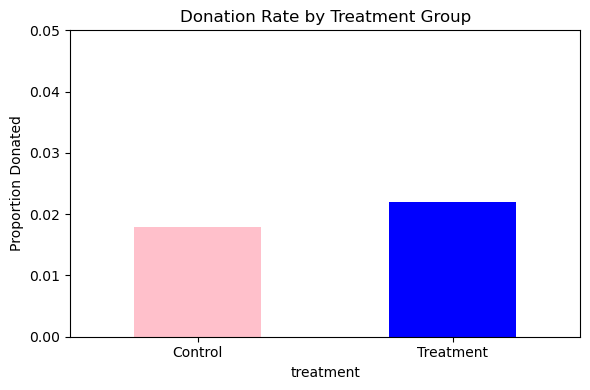

In [3]:


import statsmodels.formula.api as smf

# 创建 treatment vs control 捐款比例 barplot 所需数据
gave_by_group = df.groupby("treatment")["gave"].mean().rename({0: "Control", 1: "Treatment"})

# t-test 检验：是否捐款 (gave) 在 treatment vs control 中有显著差异
t_stat, p_value = stats.ttest_ind(
    df[df["treatment"] == 1]["gave"],
    df[df["treatment"] == 0]["gave"],
    equal_var=False
)

# 线性回归：gave ~ treatment
ols_model = smf.ols("gave ~ treatment", data=df).fit()

# Probit 回归
probit_model = smf.probit("gave ~ treatment", data=df).fit(disp=False)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))
gave_by_group.plot(kind='bar', color=["pink", "blue"], ax=ax)
ax.set_ylabel("Proportion Donated")
ax.set_title("Donation Rate by Treatment Group")
ax.set_xticklabels(["Control", "Treatment"], rotation=0)
ax.set_ylim(0, 0.05)
plt.tight_layout()


print("t =", t_stat, "p =", p_value)

print(ols_model.summary2().tables[1])

print(probit_model.summary2().tables[1])


In [4]:
# 先构建子集，只保留 matched treatment 组（treatment==1）下的不同 ratio
df_matched = df[(df["treatment"] == 1)]

# 计算每组捐赠率
rates = df_matched.groupby("ratio")["gave"].mean()
print("Donation rates by match ratio:")
print(rates)

# t-tests
from scipy.stats import ttest_ind

# 1:1 vs 2:1
p12 = ttest_ind(df_matched[df_matched["ratio"] == 1]["gave"],
                df_matched[df_matched["ratio"] == 2]["gave"],
                equal_var=False)

# 2:1 vs 3:1
p23 = ttest_ind(df_matched[df_matched["ratio"] == 2]["gave"],
                df_matched[df_matched["ratio"] == 3]["gave"],
                equal_var=False)

print(f"1:1 vs 2:1 t-test p = {p12.pvalue:.4f}")
print(f"2:1 vs 3:1 t-test p = {p23.pvalue:.4f}")

Donation rates by match ratio:
ratio
Control         NaN
1          0.020749
2          0.022633
3          0.022733
Name: gave, dtype: float64
1:1 vs 2:1 t-test p = 0.3345
2:1 vs 3:1 t-test p = 0.9600


/tmp/ipykernel_2616514/617877570.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df_matched.groupby("ratio")["gave"].mean()


In [6]:
# 创建 dummy 变量
df["ratio1"] = (df["ratio"] == 1).astype(int)
df["ratio2"] = (df["ratio"] == 2).astype(int)
df["ratio3"] = (df["ratio"] == 3).astype(int)

# 只保留 treatment==1 的 matched 组
df_matched = df[df["treatment"] == 1]

# 回归
import statsmodels.api as sm

X = df_matched[["ratio1", "ratio2", "ratio3"]]
X = sm.add_constant(X)
y = df_matched["gave"]

model = sm.OLS(y, X).fit()
model.summary2().tables[1]


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-1.597075e+09,3.428594e+11,-0.004658,0.996283,-6.736135e+11,6.704193e+11
ratio1,1.597075e+09,3.428594e+11,0.004658,0.996283,-6.704193e+11,6.736135e+11
ratio2,1.597075e+09,3.428594e+11,0.004658,0.996283,-6.704193e+11,6.736135e+11
ratio3,1.597075e+09,3.428594e+11,0.004658,0.996283,-6.704193e+11,6.736135e+11


In [7]:
# 响应率
rate_1 = df_matched[df_matched["ratio"] == 1]["gave"].mean()
rate_2 = df_matched[df_matched["ratio"] == 2]["gave"].mean()
rate_3 = df_matched[df_matched["ratio"] == 3]["gave"].mean()

print(f"1:1 vs 2:1 difference: {rate_2 - rate_1:.4f}")
print(f"2:1 vs 3:1 difference: {rate_3 - rate_2:.4f}")


1:1 vs 2:1 difference: 0.0019
2:1 vs 3:1 difference: 0.0001


In [8]:
import statsmodels.api as sm

X = df["treatment"]
X = sm.add_constant(X)
y = df["amount"]

model = sm.OLS(y, X).fit()
model.summary2().tables[1]


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.813268,0.067418,12.062995,1.843438e-33,0.681127,0.945409
treatment,0.153605,0.082561,1.860503,6.282029e-02,-0.008216,0.315426


In [9]:
df_gave = df[df["gave"] == 1]

X = df_gave["treatment"]
X = sm.add_constant(X)
y = df_gave["amount"]

model_gave = sm.OLS(y, X).fit()
model_gave.summary2().tables[1]


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,45.540268,2.423378,18.792063,5.473578e-68,40.784958,50.295579
treatment,-1.668393,2.872384,-0.580839,5.614756e-01,-7.304773,3.967986


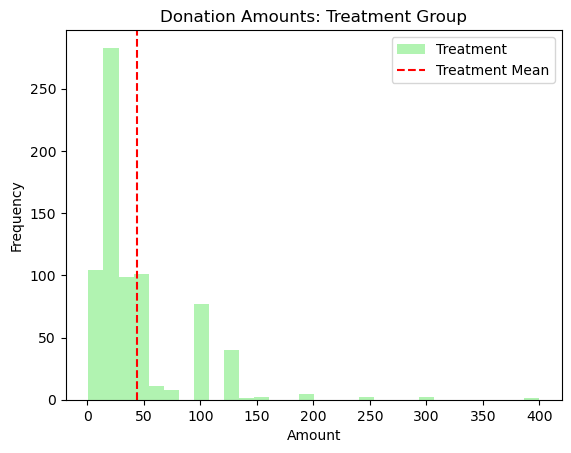

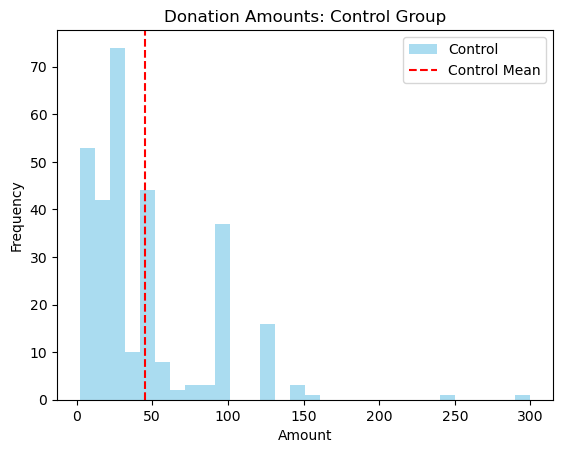

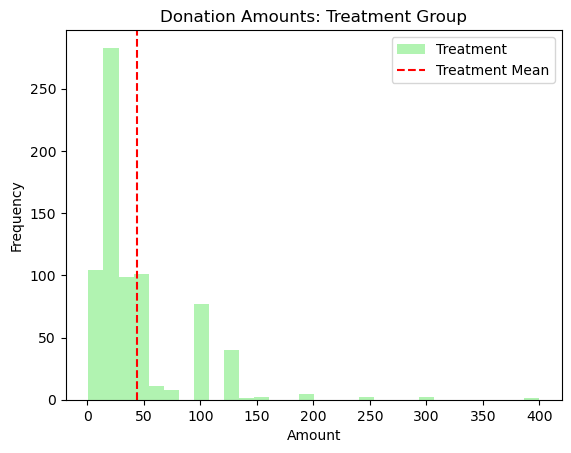

In [10]:
import matplotlib.pyplot as plt

# Prepare data
control_amounts = df[(df["treatment"] == 0) & (df["gave"] == 1)]["amount"]
treatment_amounts = df[(df["treatment"] == 1) & (df["gave"] == 1)]["amount"]

# Plot for control group
fig, ax = plt.subplots()
ax.hist(control_amounts, bins=30, alpha=0.7, label="Control", color="skyblue")
ax.axvline(control_amounts.mean(), color="red", linestyle="--", label="Control Mean")
ax.set_title("Donation Amounts: Control Group")
ax.set_xlabel("Amount")
ax.set_ylabel("Frequency")
ax.legend()
fig

# Plot for treatment group
fig, ax = plt.subplots()
ax.hist(treatment_amounts, bins=30, alpha=0.7, label="Treatment", color="lightgreen")
ax.axvline(treatment_amounts.mean(), color="red", linestyle="--", label="Treatment Mean")
ax.set_title("Donation Amounts: Treatment Group")
ax.set_xlabel("Amount")
ax.set_ylabel("Frequency")
ax.legend()
fig


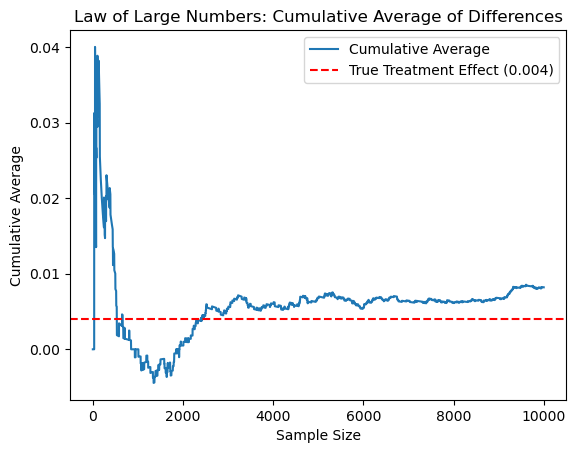

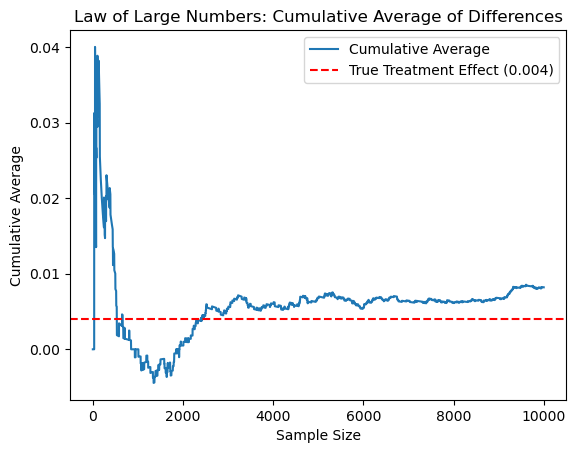

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Set probabilities
p_control = 0.018
p_treatment = 0.022
n = 10_000

# Simulate donation outcomes
np.random.seed(42)
control = np.random.binomial(n=1, p=p_control, size=n)
treatment = np.random.binomial(n=1, p=p_treatment, size=n)

# Calculate difference vector and cumulative average
diff = treatment - control
cumulative_avg = np.cumsum(diff) / np.arange(1, n + 1)

# Plot cumulative average
fig, ax = plt.subplots()
ax.plot(cumulative_avg, label="Cumulative Average")
ax.axhline(y=0.004, color="red", linestyle="--", label="True Treatment Effect (0.004)")
ax.set_title("Law of Large Numbers: Cumulative Average of Differences")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Cumulative Average")
ax.legend()
fig


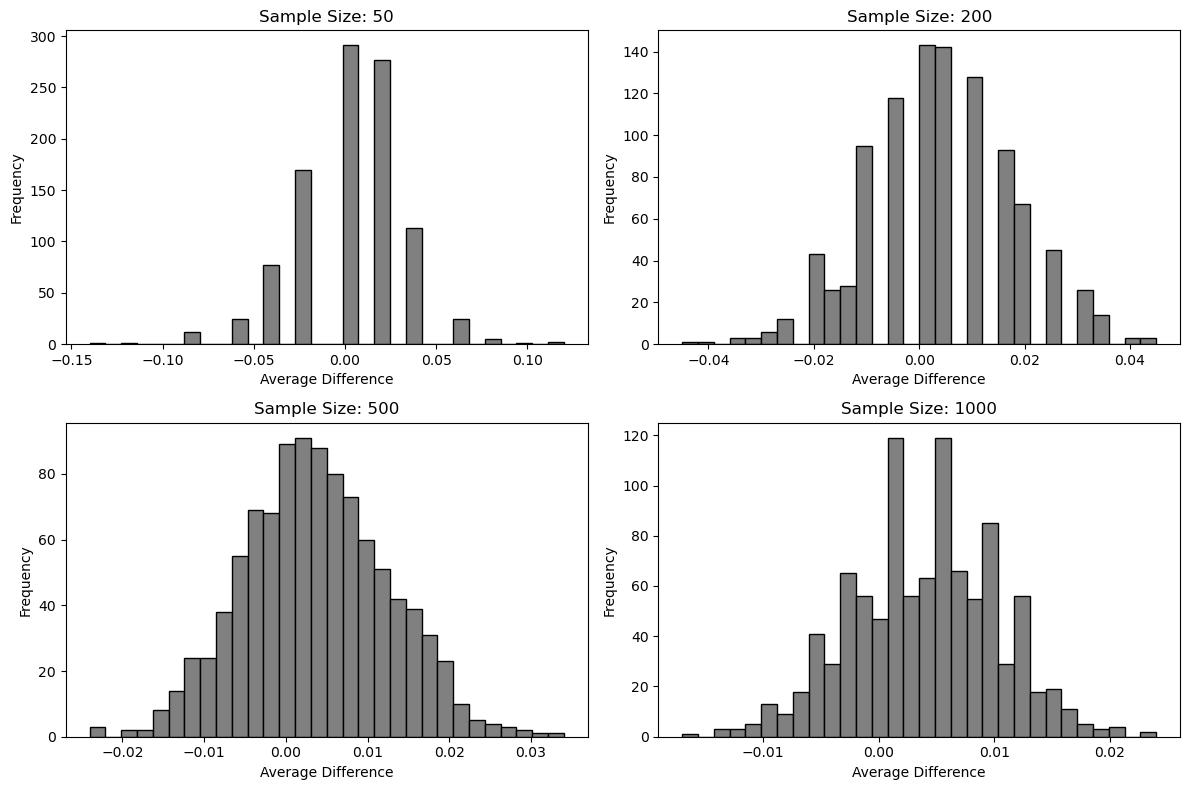

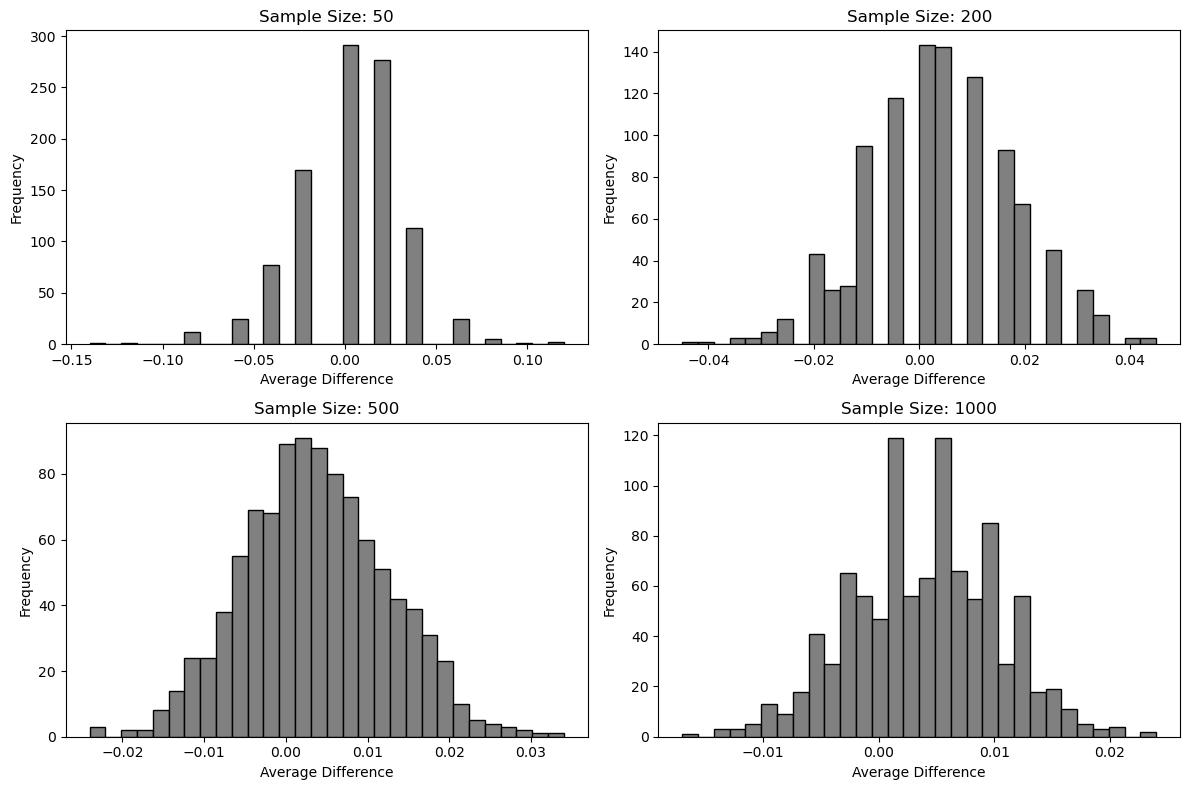

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(123)

# Simulation parameters
p_control = 0.018
p_treatment = 0.022
sample_sizes = [50, 200, 500, 1000]

# Create 4 histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, n in enumerate(sample_sizes):
    differences = []
    for _ in range(1000):
        control = np.random.binomial(1, p_control, n)
        treatment = np.random.binomial(1, p_treatment, n)
        diff = treatment.mean() - control.mean()
        differences.append(diff)

    ax = axs[i // 2, i % 2]
    ax.hist(differences, bins=30, color="grey", edgecolor="black")
    ax.set_title(f"Sample Size: {n}")
    ax.set_xlabel("Average Difference")
    ax.set_ylabel("Frequency")

plt.tight_layout()
fig
